<a href="https://colab.research.google.com/github/tcharrisson/HDSC-Winter-22-Capstone-Project/blob/production/densenet_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet121

In [2]:
from google.colab import files

files.upload()

{}

In [3]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!cp ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# !kaggle datasets download -d nipunarora8/malaria-detection-dataset --unzip
!kaggle datasets download iarunava/cell-images-for-detecting-malaria

cell-images-for-detecting-malaria.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
! unzip cell-images-for-detecting-malaria.zip

Streaming output truncated to the last 5000 lines.
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_116.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_221.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_222.png  
  inflating: cell_i

In [6]:
import shutil
shutil.rmtree('cell_images/cell_images')

In [7]:
from glob import glob
import matplotlib.pyplot as plt
!pip install split-folders
import splitfolders

In [8]:

data_location = "cell_images/"
splitfolders.ratio(data_location, output='output', seed=1337, ratio=(0.7, 0.2, 0.1))

Copying files: 27560 files [00:08, 3361.32 files/s]


In [9]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [10]:
def build_densenet121_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained DenseNet121 Model """
    densenet = DenseNet121(include_top=False, weights="imagenet", input_tensor=inputs)
    
    """ Encoder """
    s1 = densenet.get_layer("input_1").output       ## 512
    s2 = densenet.get_layer("conv1/relu").output    ## 256
    s3 = densenet.get_layer("pool2_relu").output ## 128
    s4 = densenet.get_layer("pool3_relu").output  ## 64
    print(s1.shape, s2.shape, s3.shape, s4.shape)
    
    """ Bridge """
    b1 = densenet.get_layer("pool4_relu").output  ## 32
    
    d1 = decoder_block(b1, s4, 512)             ## 64
    d2 = decoder_block(d1, s3, 256)             ## 128
    d3 = decoder_block(d2, s2, 128)             ## 256
    d4 = decoder_block(d3, s1, 64)              ## 512
    print(d1.shape, d2.shape, d3.shape, d4.shape)
    
    """ Outputs """
    x = Flatten()(d4)
    outputs = Dense(2, activation="softmax")(x)
    
    model = Model(inputs, outputs)
    return model
    
if __name__ == "__main__":
    input_shape = (64, 64, 3)
    model = build_densenet121_unet(input_shape)
    model.summary()

(None, 64, 64, 3) (None, 32, 32, 64) (None, 16, 16, 256) (None, 8, 8, 512)
(None, 8, 8, 512) (None, 16, 16, 256) (None, 32, 32, 128) (None, 64, 64, 64)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 32, 32, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 32

In [11]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

val_datagen = ImageDataGenerator(rescale = 1./255)

In [13]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/content/output/train',
                                                 target_size=(64, 64),
                                                 batch_size=32,
                                                 class_mode='categorical')

Found 19290 images belonging to 2 classes.


In [14]:
val_set = val_datagen.flow_from_directory('/content/output/val',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 5512 images belonging to 2 classes.


In [15]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory('/content/output/test',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 2756 images belonging to 2 classes.


In [16]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit(training_set,
              validation_data=val_set,
              epochs=20,
              steps_per_epoch=len(training_set),
              validation_steps=len(val_set))

Epoch 1/20
603/603 [==============================] - 212s 316ms/step - loss: 1.1557 - accuracy: 0.7188 - val_loss: 0.3461 - val_accuracy: 0.8621
Epoch 2/20
603/603 [==============================] - 184s 304ms/step - loss: 0.1886 - accuracy: 0.9406 - val_loss: 0.1593 - val_accuracy: 0.9507
Epoch 3/20
603/603 [==============================] - 183s 304ms/step - loss: 0.1743 - accuracy: 0.9461 - val_loss: 0.2177 - val_accuracy: 0.9394
Epoch 4/20
603/603 [==============================] - 182s 301ms/step - loss: 0.1512 - accuracy: 0.9516 - val_loss: 0.1497 - val_accuracy: 0.9583
Epoch 5/20
603/603 [==============================] - 182s 302ms/step - loss: 0.1383 - accuracy: 0.9555 - val_loss: 0.1282 - val_accuracy: 0.9579
Epoch 6/20
603/603 [==============================] - 183s 303ms/step - loss: 0.1485 - accuracy: 0.9530 - val_loss: 0.1414 - val_accuracy: 0.9545
Epoch 7/20
603/603 [==============================] - 183s 303ms/step - loss: 0.1401 - accuracy: 0.9561 - val_loss: 0.1323 -

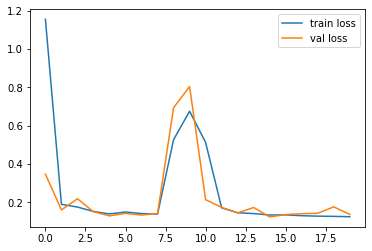

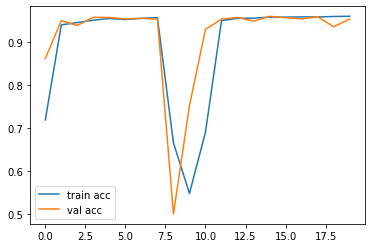

<Figure size 432x288 with 0 Axes>

In [17]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [18]:
# save it as a h5 file


from tensorflow.keras.models import load_model

model.save('model_densenet.h5')

In [19]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [20]:
model1=load_model('model_densenet.h5')